In [1]:
import torch
import torch.nn.functional as F
import random
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import skimage.io
import skimage.color
import skimage.filters
import skimage.exposure
from skimage import feature, measure
from skimage.draw import line
from skimage.transform import probabilistic_hough_line
from scipy.spatial import distance
from scipy.ndimage import convolve
from scipy.signal import convolve2d

import time
import math

import cv2


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#testing with sample image to see if indeed we get potential vanishing points

In [2]:
image = skimage.io.imread("image.jpg")

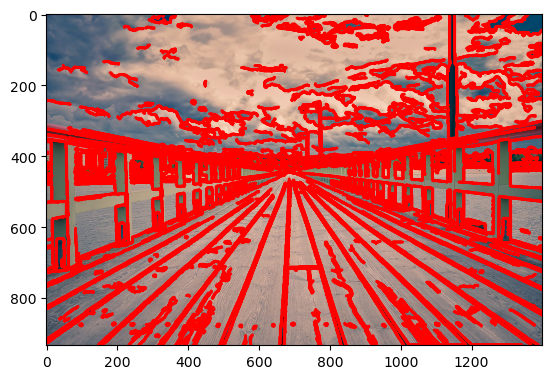

In [3]:
from skimage import io, color, feature
import matplotlib.pyplot as plt



# Convert the image to grayscale
gray_image = color.rgb2gray(image)

# Apply Canny edge detection
edges = feature.canny(gray_image, sigma=2.0)

# Find contours
contours = measure.find_contours(edges, 0.8)

# Create a copy of the image to draw lines on
image_with_lines = image.copy()

# Draw the detected lines on the image
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], '-r', linewidth=2)

# Display the resulting image with detected lines
plt.imshow(image_with_lines)
plt.show()

Testing using Hough transform

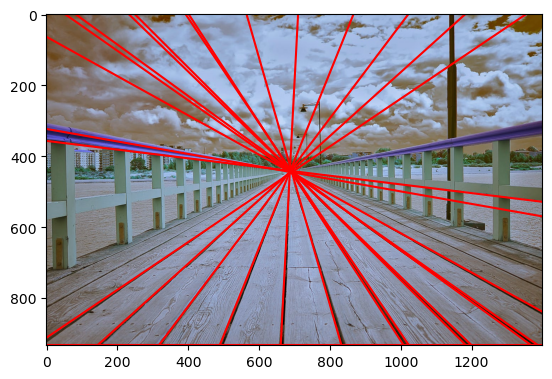

In [4]:
import cv2
import numpy as np
from skimage import feature
from skimage.transform import hough_line, hough_line_peaks
import matplotlib.pyplot as plt

# Load an image
image = cv2.imread("image.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Edge detection using skimage
edges = feature.canny(gray, sigma=3)

# Line detection using Hough Transform in skimage
h, theta, d = hough_line(edges)

# Find peaks in the Hough space to get lines
peaks = hough_line_peaks(h, theta, d, threshold=0.5 * h.max())

# Filter and draw the lines
for _, angle, dist in zip(*peaks):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - gray.shape[1] * np.cos(angle)) / np.sin(angle)
    plt.plot((0, gray.shape[1]), (y0, y1), '-r')



plt.imshow(image)
plt.show()


Tried gaussian transform but turns out too computationally intensive for google colab

In [5]:
#too computationally intensive
'''
import cv2
import numpy as np
from skimage.feature import corner_harris, corner_peaks
from skimage.draw import line
import matplotlib.pyplot as plt

# Load an image
image = cv2.imread("image.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Laplacian of Gaussian (LoG) for edge detection
edges = cv2.Laplacian(gray, cv2.CV_64F)
edges = cv2.convertScaleAbs(edges)

# Find Harris corners
coords = corner_peaks(corner_harris(edges), min_distance=5)

# Detect lines connecting the corners
lines = []
for i in range(len(coords)):
    for j in range(i + 1, len(coords)):
        start_point = tuple(map(int, coords[i]))
        end_point = tuple(map(int, coords[j]))

        rr, cc = line(start_point[0], start_point[1], end_point[0], end_point[1])
        line_coords = list(zip(rr, cc))
        lines.append(line_coords)

# Draw the detected lines
for line_coords in lines:
    for x, y in line_coords:
        image[y, x] = [0, 0, 255]

plt.imshow(image)
plt.show()
'''

'\nimport cv2\nimport numpy as np\nfrom skimage.feature import corner_harris, corner_peaks\nfrom skimage.draw import line\nimport matplotlib.pyplot as plt\n\n# Load an image\nimage = cv2.imread("image.jpg")\ngray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)\n\n# Apply Laplacian of Gaussian (LoG) for edge detection\nedges = cv2.Laplacian(gray, cv2.CV_64F)\nedges = cv2.convertScaleAbs(edges)\n\n# Find Harris corners\ncoords = corner_peaks(corner_harris(edges), min_distance=5)\n\n# Detect lines connecting the corners\nlines = []\nfor i in range(len(coords)):\n    for j in range(i + 1, len(coords)):\n        start_point = tuple(map(int, coords[i]))\n        end_point = tuple(map(int, coords[j]))\n\n        rr, cc = line(start_point[0], start_point[1], end_point[0], end_point[1])\n        line_coords = list(zip(rr, cc))\n        lines.append(line_coords)\n\n# Draw the detected lines\nfor line_coords in lines:\n    for x, y in line_coords:\n        image[y, x] = [0, 0, 255]\n\nplt.imshow(image)

Attempting to check lines using contour method

/tmp/ipykernel_66132/4094097452.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x1 = int(x - 100)
/tmp/ipykernel_66132/4094097452.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y1 = int(m * (x - 100) + b)
/tmp/ipykernel_66132/4094097452.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x2 = int(x + 100)
/tmp/ipykernel_66132/4094097452.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. E

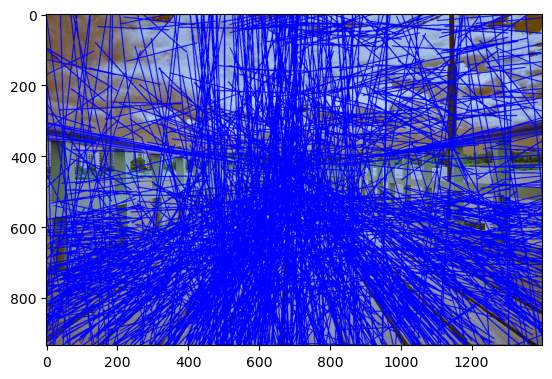

In [6]:


# Load an image
image = cv2.imread("image.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply a basic edge detection algorithm
edges = cv2.Canny(gray, threshold1=50, threshold2=150)

# Find contours using the edges
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Initialize a list to store line segments
lines = []

# Set a minimum length threshold for detected lines
min_line_length = 20

# Iterate through the contours
for contour in contours:
    if len(contour) >= min_line_length:
        # Fit a line to the contour using the least-squares method
        vx, vy, x, y = cv2.fitLine(contour, cv2.DIST_L2, 0, 0.01, 0.01)
        m = vy / vx
        b = y - m * x
        x1 = int(x - 100)
        y1 = int(m * (x - 100) + b)
        x2 = int(x + 100)
        y2 = int(m * (x + 100) + b)
        lines.append((x1, y1, x2, y2))

# Draw the detected lines
for line in lines:
    x1, y1, x2, y2 = line
    cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2)

plt.imshow(image)
plt.show()


Beginning of Acculumation step, going with contour method as it seems to give  good results based on the computational power accessable

/tmp/ipykernel_66132/1115571990.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x1 = int(x - 100)
/tmp/ipykernel_66132/1115571990.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y1 = int(m * (x - 100) + b)
/tmp/ipykernel_66132/1115571990.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x2 = int(x + 100)
/tmp/ipykernel_66132/1115571990.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. E

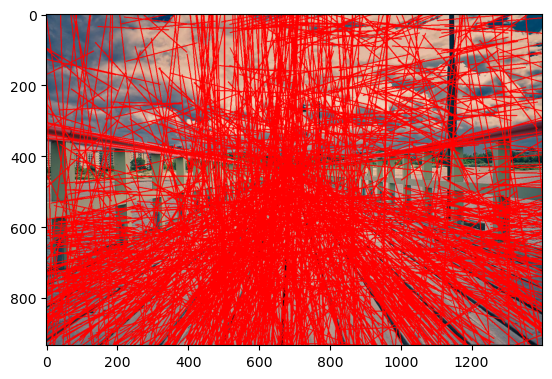

In [7]:


def detect_lines_and_visualize(image_path, min_line_length=20):
    """
    Detect lines in an image, return line coordinates, and visualize the lines.

    Args:
        image_path (str): Path to the input image.
        min_line_length (int): Minimum length threshold for detected lines.

    Returns:
        lines (list): List of line coordinates as tuples (x1, y1, x2, y2).
        is_infinite (list): List of boolean values indicating whether each line is at infinity.
        image_with_lines (ndarray): The input image with detected lines drawn on it.
    """
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply a basic edge detection algorithm
    edges = cv2.Canny(gray, threshold1=50, threshold2=150)

    # Find contours using the edges
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize lists to store line segments and their infinity status
    lines = []
    is_infinite = []

    # Create a copy of the original image to draw lines on
    image_with_lines = image.copy()

    # Iterate through the contours
    for contour in contours:
        if len(contour) >= min_line_length:
            # Fit a line to the contour using the least-squares method
            vx, vy, x, y = cv2.fitLine(contour, cv2.DIST_L2, 0, 0.01, 0.01)
            m = vy / vx if vx != 0 else np.inf  # Calculate slope and handle vertical lines

            if np.isinf(m):
                is_infinite.append(True)
            else:
                is_infinite.append(False)

            b = y - m * x
            x1 = int(x - 100)
            y1 = int(m * (x - 100) + b)
            x2 = int(x + 100)
            y2 = int(m * (x + 100) + b)

            lines.append((x1, y1, x2, y2))

            # Draw the line on the image
            cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 0, 255), 2)

    return lines, is_infinite, image_with_lines

# Example usage:
lines, is_infinite, image_with_lines = detect_lines_and_visualize("image.jpg")
'''
for i, line in enumerate(lines):
    print(f"Line {i + 1}: {line} (Is Infinite: {is_infinite[i]})")
    '''

# Display the image with detected lines
plt.imshow(cv2.cvtColor(image_with_lines, cv2.COLOR_BGR2RGB))
plt.show()


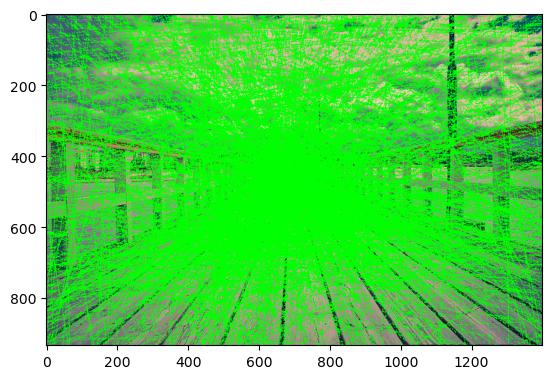

In [26]:
def is_within_bounds(point, width, height):
    x, y = point
    return 0 <= x < width and 0 <= y < height

def find_and_visualize_intersections(lines, image_path, visualize=False):
    # Read the input image
    image = cv2.imread(image_path)
    image_with_intersections = image.copy()  # Create a copy of the original image

    height, width, _ = image.shape  # Get image dimensions

    # Initialize a list to store the intersection points
    intersections = []

    for i in range(len(lines)):
        for j in range(i + 1, len(lines)):
            # Extract line coordinates
            x1, y1, x2, y2 = lines[i]
            x3, y3, x4, y4 = lines[j]

            # Calculate the intersection point
            det = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)

            if det != 0:
                px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / det
                py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / det

                intersection_point = (px, py)

                # Check if the intersection point is within the image bounds
                if is_within_bounds(intersection_point, width, height):
                    intersections.append(intersection_point)

    if(visualize):
      # Draw circles at intersection points
      for intersection in intersections:
          x, y = map(int, intersection)
          cv2.circle(image_with_intersections, (x, y), 1, (0, 255, 0), -1)  # Green circles

      # Display the image with intersection points
      plt.imshow(cv2.cvtColor(image_with_intersections, cv2.COLOR_BGR2RGB))
      plt.show()

    return intersections

# Example usage:
intersections = find_and_visualize_intersections(lines, "image.jpg",True)


In [9]:
for i in range(1000):
  print(intersections[i])

(725.3566176470588, 929.3589154411765)
(462.50602409638554, 922.7876506024096)
(237.5, 917.1625)
(262.4671814671815, 917.7866795366796)
(698.877358490566, 928.6969339622641)
(719.7541528239203, 929.218853820598)
(566.25, 925.38125)
(547.0379506641366, 924.9009487666034)
(587.8169440242058, 925.9204236006051)
(856.6712328767123, 932.6417808219178)
(770.4871794871794, 930.4871794871794)
(384.2093023255814, 920.8302325581395)
(357.0, 920.15)
(347.3720930232558, 919.9093023255814)
(603.23, 926.30575)
(540.2435643564356, 924.7310891089109)
(235.34188034188034, 917.108547008547)
(293.60869565217394, 918.5652173913044)
(654.2411924119241, 927.5810298102981)
(493.9775784753363, 923.5744394618835)
(372.37110481586404, 920.5342776203966)
(577.2162162162163, 925.6554054054054)
(727.2147435897435, 929.4053685897436)
(793.1470588235294, 931.0536764705882)
(525.1390374331551, 924.3534759358289)
(456.3580901856764, 922.6339522546419)
(409.8525641025641, 921.4713141025641)
(552.5339805825242, 925.0383

In [10]:
def calculate_line_length(x1, y1, x2, y2):

    length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return length

def point_to_line_distance(x, y, x1, y1, x2, y2):
    # Calculate the distance from a point to a line defined by (x1, y1) and (x2, y2)
    line_length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    mask = (line_length != 0)
    distance = np.where(mask, np.abs((y2 - y1) * x - (x2 - x1) * y + x2 * y1 - y2 * x1) / line_length, np.sqrt((x - x1) ** 2 + (y - y1) ** 2))
    return distance

In [11]:
'''
def vote_calc(lines,is_infinite,intersections):
  w1, w2, ta = 0.3, 0.7, 5
  vanishing_point_votes = []
  # Find the maximum length
  lengths = [calculate_line_length(x1, y1, x2, y2) for x1, y1, x2, y2 in lines]
  max_length = max(lengths)
  for point in intersections:
    votes = 0
    #print(point)
    x,y=point
    for line in lines:
      x1,y1,x2,y2 = line
      #print(x,y,x1,y1,x2,y2)
      distance = point_to_line_distance(x,y,x1,y1,x2,y2)
      #print(w1 * (1 - distance/ta))
      vote= (w1 * (1 - (distance / ta))) + w2 * (calculate_line_length(x1, y1, x2, y2) / max_length)
      votes=+vote
    vanishing_point_votes.append([x,y,votes])
    break
  return vanishing_point_votes
'''

'\ndef vote_calc(lines,is_infinite,intersections):\n  w1, w2, ta = 0.3, 0.7, 5\n  vanishing_point_votes = []\n  # Find the maximum length\n  lengths = [calculate_line_length(x1, y1, x2, y2) for x1, y1, x2, y2 in lines]\n  max_length = max(lengths)\n  for point in intersections:\n    votes = 0\n    #print(point)\n    x,y=point\n    for line in lines:\n      x1,y1,x2,y2 = line\n      #print(x,y,x1,y1,x2,y2)\n      distance = point_to_line_distance(x,y,x1,y1,x2,y2)\n      #print(w1 * (1 - distance/ta))\n      vote= (w1 * (1 - (distance / ta))) + w2 * (calculate_line_length(x1, y1, x2, y2) / max_length)\n      votes=+vote\n    vanishing_point_votes.append([x,y,votes])\n    break\n  return vanishing_point_votes\n'

In [12]:
def calculate_vanishing_point_votes(lines, is_infinite, intersections, w1=0.3, w2=0.7, ta=5):
    # Calculate line lengths in a vectorized manner
    line_lengths = np.array([calculate_line_length(x1, y1, x2, y2) for x1, y1, x2, y2 in lines])
    max_length = np.max(line_lengths)

    vanishing_point_votes = []

    for point in intersections:
        x, y = point
        x1, y1, x2, y2 = np.array(lines).T

        # Calculate distances in a vectorized manner
        distances = point_to_line_distance(x, y, x1, y1, x2, y2)
        distance_weights = w1 * (1 - distances / ta)
        length_weights = w2 * (line_lengths / max_length)

        votes = np.sum(distance_weights + length_weights)
        vanishing_point_votes.append([x, y, votes])

    return vanishing_point_votes


In [13]:
vanishing_point_votes = calculate_vanishing_point_votes(lines,is_infinite,intersections)
print(vanishing_point_votes[0])

[725.3566176470588, 929.3589154411765, -33685.96170604857]


In [14]:
#print(vote_calc(lines,is_infinite,intersections))

In [15]:
print(intersections[0])

(725.3566176470588, 929.3589154411765)


In [16]:
lengths = [calculate_line_length(x1, y1, x2, y2) for x1, y1, x2, y2 in lines]
print(max(lengths))

160001.12499916993


In [17]:

def calculate_angle(ai,aj):
    # Calculate the angle in degrees between two points with respect to the x-axis
		dx, dy, _ = np.array(ai) - np.array(aj)
		angle_degrees = np.degrees(np.arctan2(dy, dx))
		return angle_degrees

In [18]:
def calculate_distance_and_angle(ai,aj):
    x1,y1,_ = ai
    x2,y2,_ = aj
    distance=calculate_line_length(x1,y1,x2,y2)
    angle=calculate_angle(ai,aj)
    return distance, angle

In [19]:
def _vanishing_line_criterion_(ai,aj,td,talpha):

		# Use the distance function to get distance and angle
		distance, angle = calculate_distance_and_angle(ai, aj)
		#print(distance,angle)
		# Check if the distance and angle are below the thresholds
		if distance < td and angle < talpha:
			return True  # The vanishing point criterion is fulfilled
		return False  # The vanishing point criterion is not fulfilled

In [20]:
def calculate_slope(ai,aj):
    x1,y1,_ = ai
    x2,y2,_ = aj
    # Check for division by zero to avoid errors
    if x1 == x2:
        return "Undefined (Vertical Line)"
    else:
        return (y2 - y1) / (x2 - x1)

In [21]:
def orthoganality_camera_criterion(a1,ai,aj,point_difference_max,image_mid):
    #check if all angles are less than 90
    angle1=calculate_angle(a1,ai)
    angle2=calculate_angle(ai,aj)
    angle3=calculate_angle(aj,a1)
    # Define the 2D points as a list of (x, y) coordinates
    points = [(a1[0], a1[1]), (ai[0],ai[1]), (aj[0],aj[1])]

    # Calculate the midpoint of the first two points
    principal_x = (points[0][0] + points[1][0]) / 2
    principal_y = (points[0][1] + points[1][1]) / 2
    principal = (principal_x, principal_y)

    image_mid_x,image_mid_y=image_mid
    difference_principal_midpoint=calculate_line_length(principal_x,principal_y,image_mid_x,image_mid_y)
    if angle1 < 90 and angle2 < 90 and angle3 < 90 and difference_principal_midpoint < point_difference_max:
      #if np.isclose(slope(a1,ai) / slope(a1,aj), slope(a1,aj) / slope(ai,aj)):
      return True
    else:
      return False


In [22]:
print(vanishing_point_votes[0][2])

-33685.96170604857


Search step and also the sample hypothesis function

In [23]:
def search_step(img,lines,vanishing_point_votes,td=100,talpha=30,max_vote=-40000):
  height, width = img.shape
  image_mid=(width//2,height//2)
  #print(image_mid)
  point_difference_max=(math.sqrt(width**2 + height**2)*.43)
  #print(point_difference_max)
  # Find the item with the maximum votes
  a1 = max(vanishing_point_votes, key=lambda item: item[2])
  #print(a1)
  # Create a list without the item with maximum votes
  eligible_votes = [item for item in vanishing_point_votes if item != a1]
  tries = 5000
  ai= eligible_votes[0]
  aj= eligible_votes[2]
  for i in range(tries):
    random_indices = random.sample(eligible_votes, 2)
    ai,aj= random_indices
    #print(a1,ai,aj)
    #print(_vanishing_line_criterion_(a1,ai,td,talpha),_vanishing_line_criterion_(ai,aj,td,talpha),_vanishing_line_criterion_(a1,aj,td,talpha))
    if _vanishing_line_criterion_(a1,ai,td,talpha) and _vanishing_line_criterion_(ai,aj,td,talpha) and _vanishing_line_criterion_(a1,aj,td,talpha):
      print("vanishing criterion passed")
      if orthoganality_camera_criterion(a1,ai,aj,point_difference_max,image_mid):
        print("orthoganality camera passed")
        final_vote = a1[2] + ai[2] + aj[2]
        #print(a1,ai,aj)
        if final_vote > max_vote:
          #print(final_vote)
          #print(a1,ai,aj)
          tries=tries-1
          break
  if tries > 0:
    # Define the 2D points as a list of (x, y) coordinates
    points = [(a1[0], a1[1]), (ai[0],ai[1]), (aj[0],aj[1])]

    # Calculate the midpoint of the first two points
    midpoint_x = (points[0][0] + points[1][0]) / 2
    midpoint_y = (points[0][1] + points[1][1]) / 2
    midpoint = (midpoint_x, midpoint_y)
    return a1,ai,aj,True
  else:
    return 0,0,0,False
  pass

In [24]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
a1,ai,aj,_ = search_step(gray,lines,vanishing_point_votes)

vanishing criterion passed
vanishing criterion passed
vanishing criterion passed
vanishing criterion passed
vanishing criterion passed
vanishing criterion passed
orthoganality camera passed
vanishing criterion passed
vanishing criterion passed
vanishing criterion passed
orthoganality camera passed


Testing out the Search step and the final result by hand for a sample image

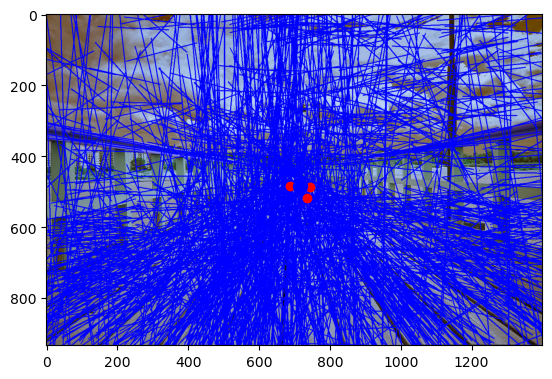

In [27]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the 2D points as a list of (x, y) coordinates
points = [(a1[0], a1[1]), (ai[0],ai[1]), (aj[0],aj[1])]

# Calculate the midpoint of the first two points
midpoint_x = (points[0][0] + points[1][0]) / 2
midpoint_y = (points[0][1] + points[1][1]) / 2
midpoint = (midpoint_x, midpoint_y)

# Create a Matplotlib figure and axis
fig, ax = plt.subplots()

# Display the image
ax.imshow(image)

# Plot the 2D points on the image
for point in points:
    x, y = point
    ax.plot(x, y, 'ro')  # 'ro' for red circles

# Plot the midpoint as a blue circle
mid_x, mid_y = midpoint
ax.plot(mid_x, mid_y, 'bo', markersize=10)  # 'bo' for blue circle


# Show the image with the plotted points and midpoint
plt.show()


Now to train a model using these functions and more


In [29]:
import scipy.io
mat = scipy.io.loadmat('./data/YorkUrbanDB/P1020171/P1020171GroundTruthVP_CamParams.mat')
print(mat)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Wed Jan 16 21:15:11 2008', '__version__': '1.0', '__globals__': [], 'vp_std_error': array([[     0.        , 156103.87648279, 103827.29366751]]), 'vp': array([[-0.76923989, -0.06964852,  0.63526196],
       [-0.15739971,  0.98406444, -0.08427292],
       [ 0.61926999,  0.16360399,  0.76768504]])}


In [ ]:
import zipfile

zip_file_path = "./data/YorkUrbanDB.zip"  # Replace with the path to your ZIP file
extracted_dir = "./data/"  # Replace with the directory where you want to extract the files

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)
